In [1]:
%matplotlib widget

I'm in the process of implementing the dynamic sigma for the highpass filtering and want to see how filtering affects the data

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
import pathlib
from scipy import ndimage

In [3]:
from xml.etree import ElementTree as ET

def load_timestamps(path_to_metadata):
    """
    NEW:
    Parses a Bruker xml file to get the times of each frame
    :param path_to_metadata: a full filepath to a recording_metadata.xml file
    return: timestamps: [t,z] numpy array of times (in ms) of Bruker imaging frames.

    ORIGINAL:

    Parses a Bruker xml file to get the times of each frame, or loads h5py file if it exists.

    First tries to load from 'timestamps.h5' (h5py file). If this file doesn't exist
    it will load and parse the Bruker xml file, and save the h5py file for quick loading in the future.

    Parameters
    ----------
    directory: full directory that contains xml file (str).
    file: Defaults to 'functional.xml'

    Returns
    -------
    timestamps: [t,z] numpy array of times (in ms) of Bruker imaging frames.

    """
    # Not sure if h5py really needs to be made...We only need the timestamps once per call
    # and it's different for each recording...
    # if '.h5' in path_to_metadata:
    # try:
    #    print('Trying to load timestamp data from hdf5 file.')
    #    #with h5py.File(os.path.join(directory, 'timestamps.h5'), 'r') as hf:
    #    with h5py.File(path_to_metadata, 'r') as hf:
    #        timestamps = hf['timestamps'][:]

    # except:
    # else:
    # print('Failed. Extracting frame timestamps from bruker xml file.')
    # xml_file = os.path.join(directory, file)
    # xml_file = pathlib.Path(directory, file)

    tree = ET.parse(path_to_metadata)
    root = tree.getroot()
    timestamps = []

    sequences = root.findall("Sequence")
    for sequence in sequences:
        frames = sequence.findall("Frame")
        for frame in frames:
            # filename = frame.findall('File')[0].get('filename')
            time = float(frame.get("relativeTime"))
            timestamps.append(time)
    timestamps = np.multiply(timestamps, 1000)

    if len(sequences) > 1:
        timestamps = np.reshape(timestamps, (len(sequences), len(frames)))
    else:
        timestamps = np.reshape(timestamps, (len(frames), len(sequences)))

    ### Save h5py file ###
    # with h5py.File(os.path.join(directory, 'timestamps.h5'), 'w') as hf:
    #    hf.create_dataset("timestamps", data=timestamps)

    print("Success.")
    return timestamps


In [5]:
current_dataset_path = pathlib.Path('F:\\temp\\nsyb_example_nii\\channel_2_moco_zscore.nii')
timestamps = load_timestamps(pathlib.Path(current_dataset_path.parent, 'recording_metadata.xml'))

current_dataset_proxy = nib.load(current_dataset_path)
data = np.asarray(current_dataset_proxy.dataobj, dtype=np.float32)
data_mean = np.mean(data, axis=-1)
hz = (1 / np.diff(timestamps[:, 0])[0]) * 1000 # This is volumes per second!

Success.


working on sigma: 10
working on sigma: 50
working on sigma: 100
working on sigma: 200
working on sigma: 300


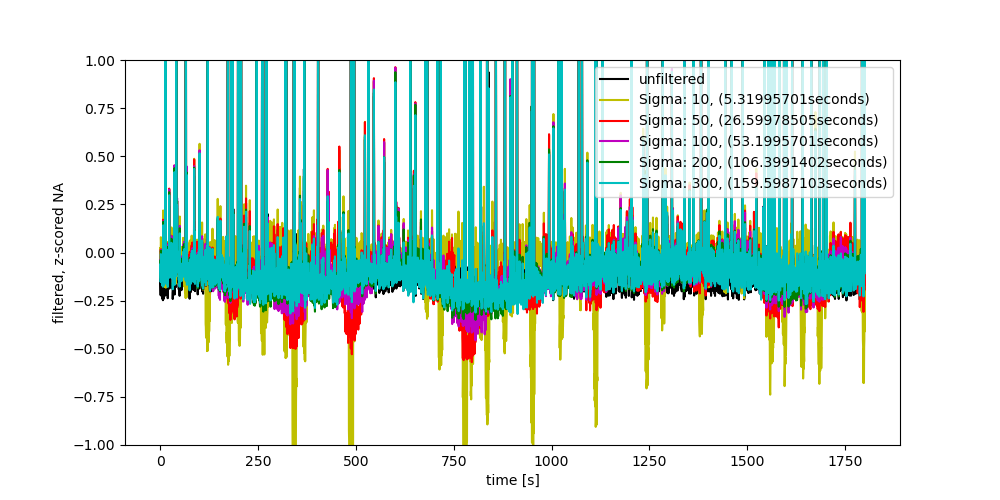

In [11]:
z_slice = 29
x_ = 50
y_ = 50

fig=plt.figure(figsize=(10,5))
ax=fig.add_subplot(111)
ax.plot(timestamps[:,z_slice]/1000, data[x_,y_,z_slice,:], c='k', label='unfiltered')

sigmas = [10,  50, 100, 200, 300]
colors = ['y','r', 'm', 'g', 'c']

for sigma, color in zip(sigmas,colors):
    smoothed_data = None # reset for each loop
    relevant_data = data[:,:,z_slice,:].copy() # Make explicit copy each loop
    relevant_data_mean = data_mean[:, :, z_slice, None].copy()
    
    print('working on sigma: ' + repr(sigma))
    # Filter
    smoothed_data = ndimage.gaussian_filter1d(
        relevant_data, sigma=sigma, axis=-1, truncate=1
    )  
    # subtract filtered data from original
    relevant_data -= smoothed_data
    # Add mean data (mean over the duration of the experiment for a given voxel)
    relevant_data += relevant_data_mean
    ax.plot(timestamps[:,z_slice]/1000, relevant_data[x_,y_,:], c=color, label='Sigma: ' + repr(sigma) + ', (' + repr(sigma/hz) + 'seconds)')

ax.set_ylim(-1, 1)
ax.set_xlabel('time [s]')
ax.set_ylabel('filtered, z-scored NA')
ax.legend()

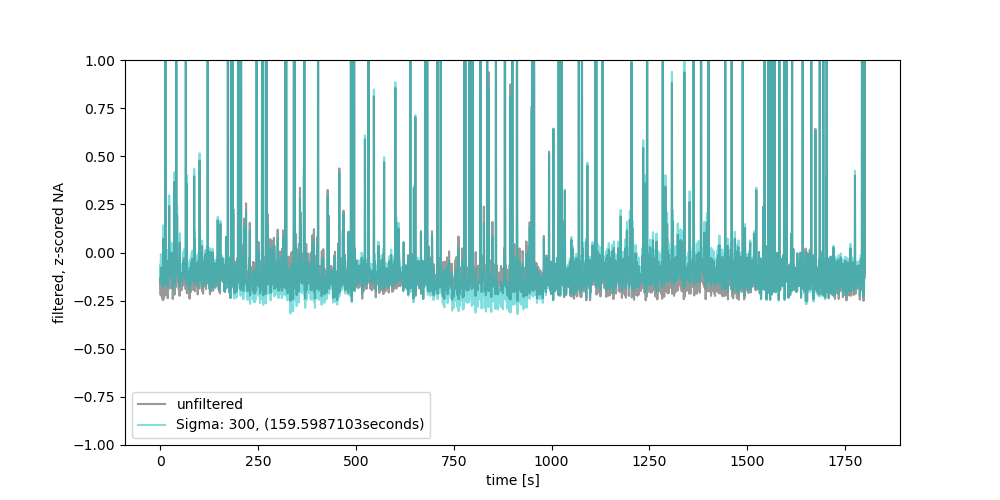

In [17]:

fig=plt.figure(figsize=(10,5))
ax=fig.add_subplot(111)
ax.plot(timestamps[:,z_slice]/1000, data[x_,y_,z_slice,:], c='k', label='unfiltered',
       alpha=0.4)
ax.plot(timestamps[:,z_slice]/1000, relevant_data[x_,y_,:], c=color, label='Sigma: ' + repr(sigma) + ', (' + repr(sigma/hz) + 'seconds)',
       alpha=0.5)
ax.set_ylim(-1, 1)
ax.set_xlabel('time [s]')
ax.set_ylabel('filtered, z-scored NA')
ax.legend()